<a href="https://colab.research.google.com/github/VictorDreke/Industry4.0_Python/blob/master/LSTM_for_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
import time

For LSTM model

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


## Load training data

In [3]:
file = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data3.txt'
train = pd.read_csv(file)

## Plot training data

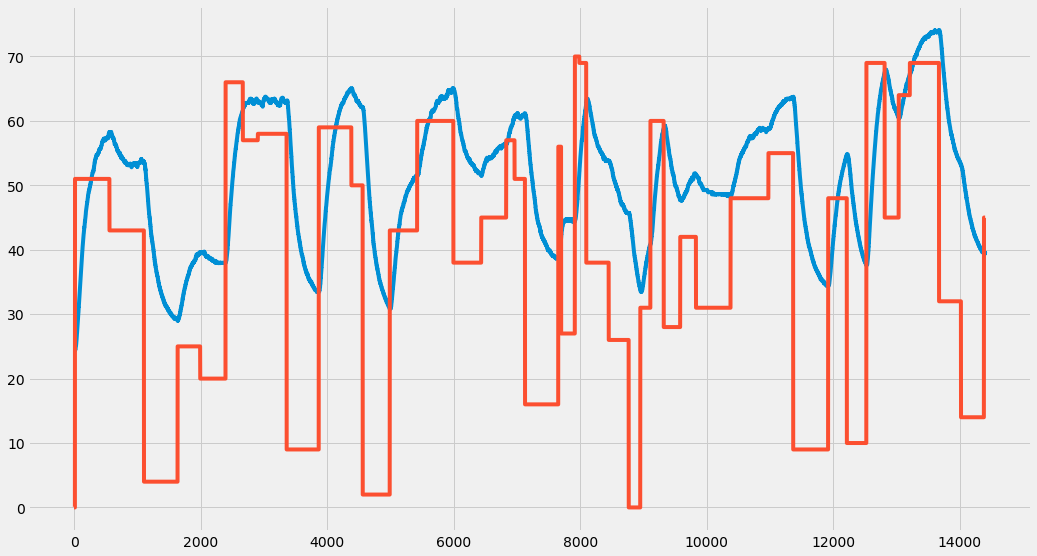

In [11]:
plt.figure(figsize=(16,9))
plt.plot(train['T1'], label='Temp')
plt.plot(train['Q1'], label='Heater')


## Pre-process data

In [12]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(train[['T1','Q1']])

# Scale predicted value
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(train[['T1']])

## Function to reshape the data

In [15]:
def dividing_data_for_lstm(Xs, Ys, window=70):
  X=[]
  Y=[]
  for i in range(window, len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])
  # Reshape data to format accepted by LSTM
  X, Y = np.array(X), np.array(Y)
  return X, Y



## Create and Train LSTM model

In [19]:
X, Y = dividing_data_for_lstm(Xs, Ys, window=70)

# Initialize LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])

# Allow for early exit 
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(X, Y, epochs = 10, batch_size = 250, callbacks=[es], verbose=1)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Epoch 1/10
14330/14330 [==============================] - 25s 2ms/step - loss: 0.0158 - accuracy: 2.0935e-04
Epoch 2/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0024 - accuracy: 2.7913e-04
Epoch 3/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0019 - accuracy: 2.7913e-04
Epoch 4/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0017 - accuracy: 2.7913e-04
Epoch 5/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0016 - accuracy: 2.7913e-04
Epoch 6/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0015 - accuracy: 2.7913e-04
Epoch 7/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0015 - accuracy: 2.7913e-04
Epoch 8/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0015 - accuracy: 2.7913e-04
Epoch 9/10
14330/14330 [==============================] - 24s 2ms/step - loss: 0.0014 - accuracy: 2.7913e-04
Epoch 10/10
14330/1

## Plot loss

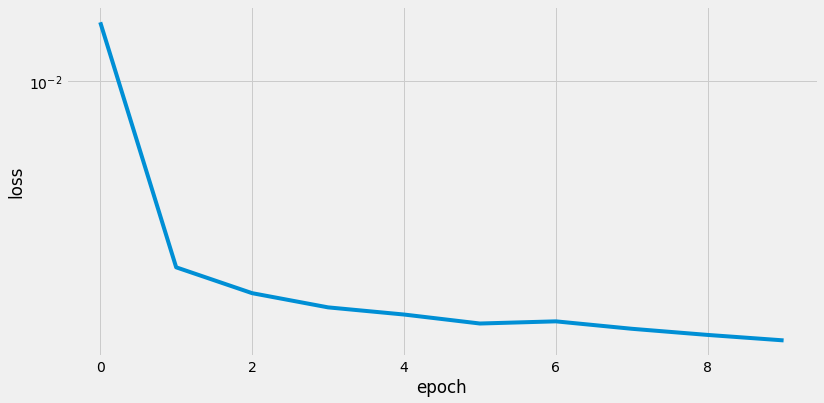

In [22]:
plt.figure(figsize=(12,6))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')
plt.savefig('tclab_loss.png')
model.save('model.h5')

## Verify the fit of the model

In [25]:
Yp = model.predict(X)

# un-scale outputs
Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)
window = 70

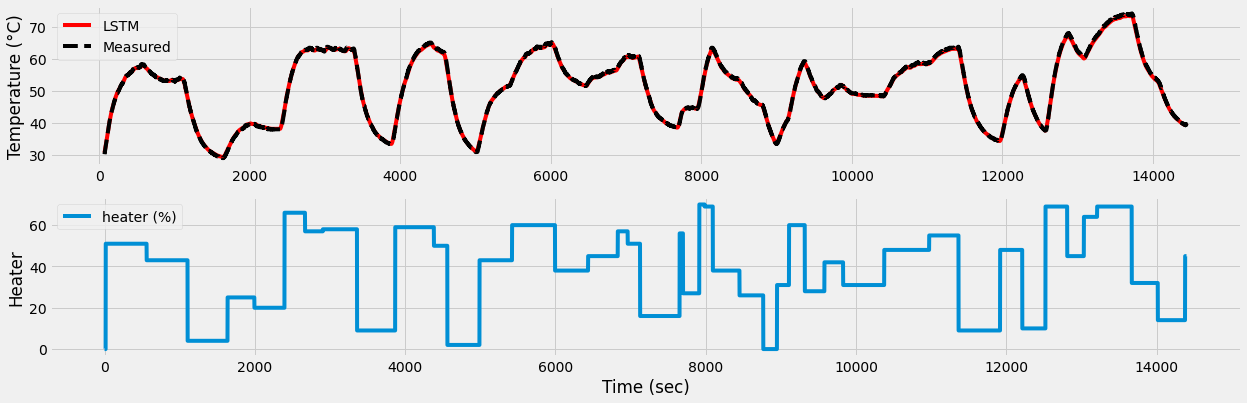

In [26]:
plt.figure(figsize=(19,6))
plt.subplot(2,1,1)
plt.plot(train['Time'][window:],Yu,'r-',label='LSTM')
plt.plot(train['Time'][window:],Ym,'k--',label='Measured')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.subplot(2,1,2)
plt.plot(train['Q1'],label='heater (%)')
plt.legend()
plt.xlabel('Time (sec)'); plt.ylabel('Heater')
plt.savefig('tclab_fit.png')

## Load model

In [28]:

v = load_model('model.h5')
# Load training data
test = pd.read_csv('https://apmonitor.com/pdc/uploads/Main/tclab_data4.txt')

Xt = test[['T1','Q1']].values
Yt = test[['T1']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

In [29]:
Xti, Yti = dividing_data_for_lstm(Xts, Yts, window=70)

In [30]:
# Verify the fit of the model
Ytp = model.predict(Xti)

# un-scale outputs
Ytu = s2.inverse_transform(Ytp)
Ytm = s2.inverse_transform(Yti)

## Ploting the test data

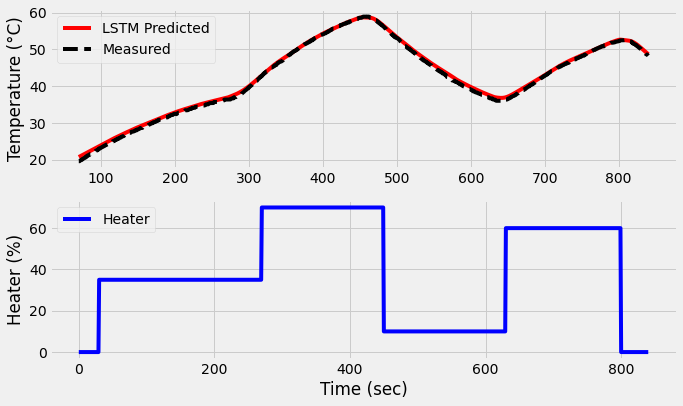

In [31]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(test['Time'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['Time'][window:],Ytm,'k--',label='Measured')
plt.legend()
plt.ylabel('Temperature (°C)')
plt.subplot(2,1,2)
plt.plot(test['Time'],test['Q1'],'b-',label='Heater')
plt.xlabel('Time (sec)'); plt.ylabel('Heater (%)')
plt.legend()
plt.savefig('tclab_validate.png')

## Using predicted values to predict next step

In [32]:
Xtsq = Xts.copy()
for i in range(window,len(Xtsq)):
    Xin = Xtsq[i-window:i].reshape((1, window, 2))
    Xtsq[i][0] = v.predict(Xin)
    Yti[i-window] = Xtsq[i][0]

#Ytu = (Yti - s2.min_[0])/s2.scale_[0]
Ytu = s2.inverse_transform(Yti)

## Plotting the test data without the past temperature values

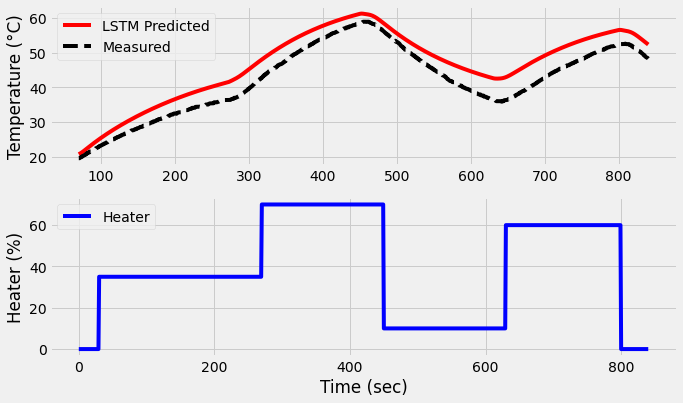

In [33]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(test['Time'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['Time'][window:],Ytm,'k--',label='Measured')
plt.legend()
plt.ylabel('Temperature (°C)')
plt.subplot(2,1,2)
plt.plot(test['Time'],test['Q1'],'b-',label='Heater')
plt.xlabel('Time (sec)'); plt.ylabel('Heater (%)')
plt.legend()
plt.savefig('tclab_forecast.png')
plt.show()